In [1]:
import torch 
import torch.nn as nn 
import torch.nn.functional as F 
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.datasets import MNIST
from torchvision import transforms
from torch.optim.lr_scheduler import MultiStepLR
import matplotlib.pyplot as plt
import numpy as np 
import torchvision

In [2]:
batch_size = 128
transform = transforms.Compose(
    [transforms.ToTensor(),])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
class Classifier(nn.Module):
  def __init__(self):
    super().__init__()
    self.net = nn.Sequential(
        nn.Conv2d(3, 48, kernel_size=3), nn.ReLU(),
        nn.Conv2d(48, 128, kernel_size=3, stride=2, padding=1), nn.ReLU(),
        nn.Conv2d(128, 256, kernel_size=3), nn.ReLU(),
        nn.Conv2d(256, 256, kernel_size=3, stride=2, padding=1), nn.ReLU(),
        nn.Conv2d(256, 128, kernel_size=3, stride=1, padding=1), nn.ReLU(),
        nn.Conv2d(128, 96, kernel_size=1, stride=1, padding=1), nn.ReLU(),
        nn.Conv2d(96, 10, kernel_size=1), 
        nn.AvgPool2d(kernel_size=8),
    )
  def forward(self, x):
    logits = self.net(x)
    return logits.view(-1, 10)

In [4]:
classifier = torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar10_resnet32", pretrained=True)
classifier = classifier.cuda()

Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Downloading: "https://github.com/chenyaofo/pytorch-cifar-models/releases/download/resnet/cifar10_resnet32-ef93fc4d.pt" to /root/.cache/torch/hub/checkpoints/cifar10_resnet32-ef93fc4d.pt


  0%|          | 0.00/1.85M [00:00<?, ?B/s]

In [5]:
def accuracy(net):
  correct = 0
  total = 0
  with torch.no_grad():
      for x,y in test_loader:
          images, labels = x.cuda(), y.cuda()
          outputs = net(images)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

  print('Accuracy: %s %%' % (100 * correct / total))

In [6]:
accuracy(classifier)

Accuracy: 89.8 %


In [7]:
class Encoder(nn.Module):
  def __init__(self):
    super().__init__()
    layers = [
              nn.Conv2d(3, 64, 5, padding=2, stride=2), nn.BatchNorm2d(64, momentum=0.9), nn.LeakyReLU(0.2),
              nn.Conv2d(64, 128, 5, padding=2, stride=2), nn.BatchNorm2d(128, momentum=0.9), nn.LeakyReLU(0.2),
              nn.Conv2d(128, 256, 5, padding=2, stride=2), nn.BatchNorm2d(256, momentum=0.9), nn.LeakyReLU(0.2),
              nn.Flatten(), nn.Linear(256*4*4, 2048), nn.BatchNorm1d(2048, momentum=0.9), nn.LeakyReLU(0.2),
              nn.Linear(2048, 118),
    ]
    self.net = nn.Sequential(*layers)

  def forward(self,x):
    return self.net(x)

In [8]:
class Decoder(nn.Module):
  def __init__(self):
    super().__init__()
    self.linear = nn.Sequential(
              nn.Linear(128, 256*4*4), nn.BatchNorm1d(256*4*4, momentum=0.9), nn.LeakyReLU(0.2),
              )
    self.conv = nn.Sequential(
        nn.ConvTranspose2d(256,256,6, stride=2, padding=2), nn.BatchNorm2d(256, momentum=0.9), nn.LeakyReLU(0.2),
        nn.ConvTranspose2d(256,128,6, stride=2, padding=2), nn.BatchNorm2d(128, momentum=0.9), nn.LeakyReLU(0.2),
        nn.ConvTranspose2d(128,32,6, stride=2, padding=2), nn.BatchNorm2d(32, momentum=0.9), nn.LeakyReLU(0.2),
        nn.ConvTranspose2d(32,3,5, stride=1, padding=2), nn.Tanh()
    )

  def forward(self, x):
    x = self.linear(x)
    x = x.view(-1, 256, 4, 4)
    return self.conv(x)

In [17]:
class Generator(nn.Module):
  def __init__(self, epsilon):
    super().__init__()
    self.decoder = Decoder()
    self.encoder = Encoder()
    self.classifier = classifier
    self.epsilon = epsilon
    for param in classifier.parameters():
      param.requires_grad = False

  def loss(self, x, y, gen_labels):
    one_hot = F.one_hot(gen_labels, 10).cuda()
    z = torch.cat((self.encoder(x), one_hot), 1)
    perturbation = self.decoder(z)
    logits = self.classifier(x+perturbation)
    predictions = F.softmax(logits, 1)
    loss = nn.CrossEntropyLoss()
    return loss(classifier(x+perturbation), gen_labels) + torch.linalg.norm(perturbation, ord=2, dim=1).mean(), perturbation

In [18]:
epsilon = 0.04
epochs = 20
model = Generator(epsilon).cuda()
lr = 1e-4
optimizer = torch.optim.Adam(model.parameters(), 1e-4)
scheduler = MultiStepLR(optimizer, milestones=[10], gamma=0.1)

for epoch in range(epochs):
  for i, (x,y) in enumerate(train_loader):
    x,y = x.cuda(), y.cuda()
    optimizer.zero_grad()
    gen_labels = torch.randint(0,10, (x.shape[0],)).cuda()
    loss, perturbation = model.loss(x,y,gen_labels)
    loss.backward()
    optimizer.step()
    scheduler.step()

    if (i%100 == 0):
        print('Epoch [{}/{}], Step [{}/{}], Loss: {}'.format(epoch+1, epochs, i+1, len(train_loader), loss.item()))

Epoch [1/20], Step [1/391], Loss: 6.119631767272949
Epoch [1/20], Step [101/391], Loss: 4.96907901763916
Epoch [1/20], Step [201/391], Loss: 3.5854837894439697
Epoch [1/20], Step [301/391], Loss: 2.799677610397339
Epoch [2/20], Step [1/391], Loss: 2.241072654724121
Epoch [2/20], Step [101/391], Loss: 1.8628957271575928
Epoch [2/20], Step [201/391], Loss: 1.5070035457611084
Epoch [2/20], Step [301/391], Loss: 1.2810546159744263
Epoch [3/20], Step [1/391], Loss: 1.2444839477539062
Epoch [3/20], Step [101/391], Loss: 1.1953045129776
Epoch [3/20], Step [201/391], Loss: 1.1001105308532715
Epoch [3/20], Step [301/391], Loss: 1.0983002185821533
Epoch [4/20], Step [1/391], Loss: 0.975552499294281
Epoch [4/20], Step [101/391], Loss: 0.9345712065696716
Epoch [4/20], Step [201/391], Loss: 0.8950679898262024
Epoch [4/20], Step [301/391], Loss: 0.8752901554107666
Epoch [5/20], Step [1/391], Loss: 0.8200432062149048
Epoch [5/20], Step [101/391], Loss: 0.8081013560295105
Epoch [5/20], Step [201/391],

In [19]:
def adv_accuracy(net):
  correct = 0
  total = 0
  with torch.no_grad():
      for x,y in test_loader:
          images, labels = x.cuda(), y.cuda()
          gen_labels = torch.randint(0,10, (x.shape[0],)).cuda()
          outputs = net(model.loss(images, labels, gen_labels)[1] + images)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

  print('Adversarial accuracy: %s %%' % (100 * correct / total))

In [20]:
adv_accuracy(classifier)

Adversarial accuracy: 9.88 %


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

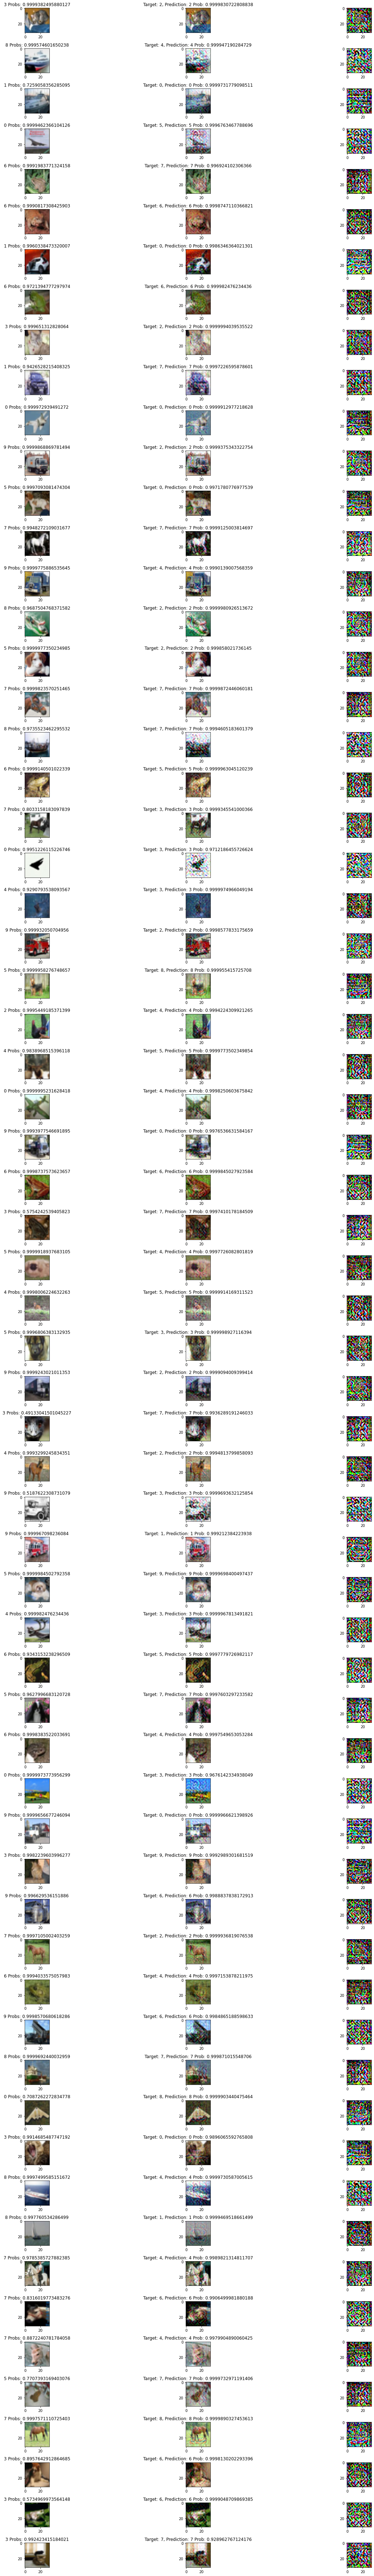

In [21]:
for x,y in test_loader:
  gen_labels = torch.randint(0,10, (128,)).cuda()
  x,y = x.cuda(), y.cuda()
  base_predictions = F.softmax(classifier(x), 1)
  _, perturbations = model.loss(x,y, gen_labels)
  new_predictions = F.softmax(classifier(x+perturbations), 1)
  fig, axs = plt.subplots(64, 3)
  fig.set_figheight(100)
  fig.set_figwidth(20)
  images = []
  for i in range(64):
          image, perturbation = x[i].detach().cpu().numpy().transpose(1,2,0), perturbations[i].detach().cpu().numpy().transpose(1,2,0)
          images.append(axs[i, 0].imshow(image))
          axs[i,0].title.set_text(f'{torch.argmax(base_predictions[i]).item()} Probs: {torch.max(base_predictions[i]).item()}')
          images.append(axs[i,1].imshow(image+perturbation))
          axs[i,1].title.set_text(f'Target: {gen_labels[i]}, Prediction: {torch.argmax(new_predictions[i]).item()} Prob: {torch.max(new_predictions[i]).item()}')
          images.append(axs[i,2].imshow(perturbation/epsilon, cmap='gray'))
  break

plt.tight_layout()
plt.show()